In [18]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [19]:
# Set up Tensorflow stuff
if not tf.test.is_built_with_cuda():
    print('Not built for a GPU!')
    
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [31]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# MNIST Classifier

In [ ]:
def preproc(imset):
    imset = imset/255.0 # convert to float from 0 to 1
    imset = imset - 0.5 # shift range to -0.5 to 0.5
    imset = imset*2.0 # finally, convert to -1 to 1
    return imset

In [ ]:
mnist = tfk.datasets.mnist
(train_images, train_labels), (val_images, val_labels) = mnist.load_data()

In [ ]:
train_images = preproc(train_images)

train_images = train_images.reshape(-1,28,28,1)

val_images = preproc(val_images)

val_images = val_images.reshape(-1,28,28,1)

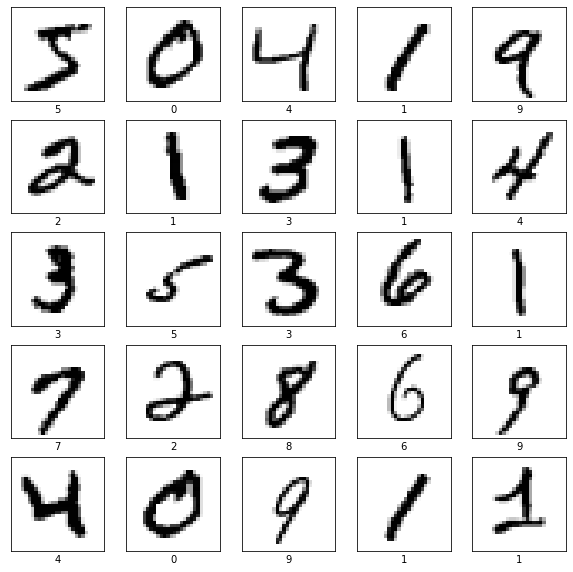

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(train_images[i]), cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()


In [ ]:
# Architecture adapted from https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist

mnist_classer = tfk.models.Sequential([
    tfkl.Conv2D(32,kernel_size=3,activation='relu',input_shape=(28,28,1)),
    tfkl.Conv2D(32,kernel_size=3,activation='relu'),
    tfkl.MaxPool2D(),
    tfkl.Dropout(0.4),
    tfkl.Conv2D(64,kernel_size=3,activation='relu'),
    tfkl.Conv2D(64,kernel_size=3,activation='relu'),
    tfkl.MaxPool2D(),
    tfkl.Dropout(0.4),
    tfkl.Flatten(),
    tfkl.Dense(128, activation='relu'),
    tfkl.Dropout(0.4),
    tfkl.Dense(10, activation='softmax'),
])

mnist_classer.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=["accuracy"])

In [ ]:
mnist_classer.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 12s 4ms/step - loss: 0.2299 - accuracy: 0.9270
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0847 - accuracy: 0.9750
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0639 - accuracy: 0.9809
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0564 - accuracy: 0.9831
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0512 - accuracy: 0.9847
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0444 - accuracy: 0.9864
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0445 - accuracy: 0.9868
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0396 - accuracy: 0.9880
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0403 - accuracy: 0.9880
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.03

In [ ]:
# We need to add the path for where to save the trained model
#mnist_classer.save()

# CIFAR10 Classifier

I tried a few different formulations but either ended up with lackluster performance or got Tensorflow type errors I wasn't familiar with. I eventually ended up trying the code from this [Kaggle tutoria](https://www.kaggle.com/code/kutaykutlu/resnet50-transfer-learning-cifar-10-beginner/notebook), and that appears to work as we expect (although it is a little slow to train, so I recommend being sure to save a copy of the trained classifier).

In [20]:
cifar10 = tfk.datasets.cifar10
(train_images, train_labels), (val_images, val_labels) = cifar10.load_data()

# train_images = tfk.applications.resnet.preprocess_input(train_images.astype('float32'))
# val_images = tfk.applications.resnet.preprocess_input(val_images.astype('float32'))

In [21]:
import PIL.Image, PIL.ImageFont, PIL.ImageDraw

In [22]:
BATCH_SIZE = 32 
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts

# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    
    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


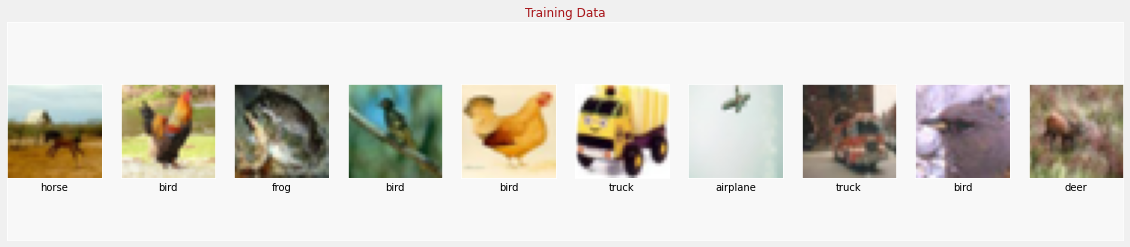

In [23]:
display_images(train_images, train_labels, train_labels, "Training Data" )

In [24]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tfk.applications.resnet50.preprocess_input(input_images)
  return output_ims


In [25]:
train_X = preprocess_image_input(train_images)
valid_X = preprocess_image_input(val_images)

In [26]:


'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_1 (UpSampling  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              2098

In [29]:
EPOCHS = 5
history = model.fit(train_X, train_labels, epochs=EPOCHS, validation_data = (valid_X, val_labels), batch_size=8)

Epoch 1/5
6250/6250 [==============================] - 681s 108ms/step - loss: 0.4230 - accuracy: 0.8580 - val_loss: 0.2531 - val_accuracy: 0.9174
Epoch 2/5
6250/6250 [==============================] - 672s 108ms/step - loss: 0.1799 - accuracy: 0.9389 - val_loss: 0.2421 - val_accuracy: 0.9261
Epoch 3/5
6250/6250 [==============================] - 676s 108ms/step - loss: 0.1080 - accuracy: 0.9634 - val_loss: 0.2072 - val_accuracy: 0.9389
Epoch 4/5
6250/6250 [==============================] - 677s 108ms/step - loss: 0.0724 - accuracy: 0.9747 - val_loss: 0.2405 - val_accuracy: 0.9292
Epoch 5/5
6250/6250 [==============================] - 676s 108ms/step - loss: 0.0541 - accuracy: 0.9820 - val_loss: 0.1846 - val_accuracy: 0.9467


In [ ]:
# We need to add the path for where to save the trained model
#model.save()